In [1]:
import os
import math
import openai
import json
from Keys import openai_keys
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn import tree
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
import joblib
import numpy as np
import pandas as pd
import random
from keybert import KeyBERT
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

openai.organization = openai_keys['organization']
openai.api_key = openai_keys['api_key']
embedding_model = "text-embedding-ada-002"

def get_embedding(text, model="text-embedding-ada-002"):
   text = text.replace("\n", " ")
   return openai.Embedding.create(input = [text], model=model)['data'][0]['embedding']


In [2]:
# Load the JSON data from the file
with open('Source/embeddings-trump.json', 'r') as json_file:
    embeddings = json.load(json_file)

In [3]:
clf = joblib.load('models/embeddingsForest_2.pkl')

In [4]:
class Analysis:
    def __init__(self, title, text, embedding, sentiment=1, probas=[0,0,0]):
        self.title = title
        self.raw = text
        self.embedding = embedding
        self.sentiment = sentiment
        self.cluster = -1
        self.probs = probas
        self.keywords = Counter()
class Cluster:
    def __init__(self, clusterIndex, element):
        self.clusterIndex = clusterIndex
        self.elements = [element]
        self.clusterName = ""
        self.keywords = Counter()
        self.clusterSize = (0, 0)
        self.clusterBuffer = element.embedding
        self.sentimentDistribution = np.array([1, 0, 0])
        self.sentimentDistribution[element.sentiment] += 1
    def calculateClusterSize(self):
        tmp = np.sum(np.square(self.clusterBuffer - np.mean(self.clusterBuffer, axis=0, keepdims=True)), axis=1)
        self.clusterSize = (np.mean(tmp).item(), np.max(tmp).item())
    def addPoint(self, point):
        self.elements.append(point)
        self.clusterBuffer = np.vstack((self.clusterBuffer, point.embedding))
        self.sentimentDistribution[point.sentiment] += 1

In [5]:
sentiments = list()
iter = 0
for analysis in embeddings:
    emb = np.array(analysis["embedding"]).reshape((1, -1))
    y = clf.predict(emb).item()
    y_pr = clf.predict_proba(emb)
    sentiments.append(Analysis(analysis["title"], analysis["text"], emb, sentiment=y, probas=y_pr))
    iter += 1
    print(str(iter) + "/" + str(len(embeddings)))

1/1380
2/1380
3/1380
4/1380
5/1380
6/1380
7/1380
8/1380
9/1380
10/1380
11/1380
12/1380
13/1380
14/1380
15/1380
16/1380
17/1380
18/1380
19/1380
20/1380
21/1380
22/1380
23/1380
24/1380
25/1380
26/1380
27/1380
28/1380
29/1380
30/1380
31/1380
32/1380
33/1380
34/1380
35/1380
36/1380
37/1380
38/1380
39/1380
40/1380
41/1380
42/1380
43/1380
44/1380
45/1380
46/1380
47/1380
48/1380
49/1380
50/1380
51/1380
52/1380
53/1380
54/1380
55/1380
56/1380
57/1380
58/1380
59/1380
60/1380
61/1380
62/1380
63/1380
64/1380
65/1380
66/1380
67/1380
68/1380
69/1380
70/1380
71/1380
72/1380
73/1380
74/1380
75/1380
76/1380
77/1380
78/1380
79/1380
80/1380
81/1380
82/1380
83/1380
84/1380
85/1380
86/1380
87/1380
88/1380
89/1380
90/1380
91/1380
92/1380
93/1380
94/1380
95/1380
96/1380
97/1380
98/1380
99/1380
100/1380
101/1380
102/1380
103/1380
104/1380
105/1380
106/1380
107/1380
108/1380
109/1380
110/1380
111/1380
112/1380
113/1380
114/1380
115/1380
116/1380
117/1380
118/1380
119/1380
120/1380
121/1380
122/1380
123/1380
1

In [6]:
X = np.zeros((len(sentiments), sentiments[0].embedding.shape[1]))
for i in range(len(sentiments)):
    X[i] = sentiments[i].embedding
clustering = DBSCAN(eps=0.51, min_samples=3).fit(X)
# clustering = KMeans(n_clusters=256, init='random', n_init=20).fit(X)
# clustering = GaussianMixture(n_components=128, n_init=1).fit(X)

C:\Users\Admin\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Admin\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


In [7]:
clusters = dict()
# labels_ = clustering.predict(X)
for i in range(len(sentiments)):
    sentiments[i].cluster = clustering.labels_[i]
    # sentiments[i].cluster = labels_[i]
    if sentiments[i].cluster in clusters:
        clusters[sentiments[i].cluster].addPoint(sentiments[i])
    else:
        clusters[sentiments[i].cluster] = Cluster(sentiments[i].cluster, sentiments[i])

for clust in clusters.values():
    clust.calculateClusterSize()

In [8]:
iter = 0
keywordsSet = set()
kw_model = KeyBERT(model='all-mpnet-base-v2')
for cluster in clusters.values():
    # prompts = [{"role": "system", "content":
    #     'Given several comments from a single cluster, name that cluster. Two individual comments are separated by three new lines. Cluster name should summarize the common idea of comments in a short phrase. The opinion of comments should be clear from the cluster name. Write the name only.'}]
    # delimeter = "\n\n\n"
    # prompt = list()
    # for _ in range(8):
    #     i = random.randint(0, len(cluster.elements) - 1)
    #     if len(str(cluster.elements[i].raw)) < 5000:
    #         prompt.append(str(cluster.elements[i].raw))
    # prompt = delimeter.join(prompt)
    # prompts.append({"role": "user", "content": prompt})
    # chat = openai.ChatCompletion.create(model="gpt-3.5-turbo", messages=prompts)
    # cluster.clusterName = chat.choices[0].message.content

    # txt = " ; ".join(list(set([cluster.elements[i].title for i in range(1, len(cluster.elements))]))) + " ; ".join([cluster.elements[i].raw for i in range(1, len(cluster.elements))])
    # keywords = kw_model.extract_keywords(txt, top_n=5, use_maxsum=True)
    # keywords.extend(kw_model.extract_keywords(txt, keyphrase_ngram_range=(2, 2), top_n=3, use_maxsum=True, exc))
    keywords = Counter()
    clusterPosts = set()
    for element in cluster.elements:
        kwords1 = [i[0] for i in kw_model.extract_keywords(element.raw, top_n=5, use_maxsum=True)]
        kwords2 = [i[0] for i in kw_model.extract_keywords(element.raw, keyphrase_ngram_range=(2, 2), top_n=2, use_maxsum=True)]
        keywords.update(kwords1)
        keywords.update(kwords2)
        element.keywords = Counter(kwords1)
        clusterPosts.update([element.title])
    for title in clusterPosts:
        keywords.update([i[0] for i in kw_model.extract_keywords(title, top_n=3)])
        keywords.update([i[0] for i in kw_model.extract_keywords(title, keyphrase_ngram_range=(2, 2), top_n=1)])
    cluster.keywords = keywords

    iter += 1
    print(str(iter) + "/" + str(len(clusters)))

1/28
2/28
3/28
4/28
5/28
6/28
7/28
8/28
9/28
10/28
11/28
12/28
13/28
14/28
15/28
16/28
17/28
18/28
19/28
20/28
21/28
22/28
23/28
24/28
25/28
26/28
27/28
28/28


In [9]:
sentimentDictionary = {'positive': list(),'negative': list(),'neutral': list()}
for sent in sentiments:
    if sent.sentiment == 2 or (sent.probs[0, 0] - sent.probs[0, 2] <= 0.05):
        sentimentDictionary['positive'].append(sent)
    elif sent.sentiment == 1 or (-0.05 <= sent.probs[0, 0] - sent.probs[0, 1] <= 0.05 and -0.05 <= sent.probs[0, 2] - sent.probs[0, 1] <= 0.05):
        sentimentDictionary['neutral'].append(sent)
    elif sent.sentiment == 0:
        sentimentDictionary['negative'].append(sent)

In [44]:
relevantKeywords = Counter()
for sent in sentimentDictionary['positive']:
    relevantKeywords.update(sent.keywords)

# print(relevantKeywords['chatgpt'])
relevantKeywords = relevantKeywords.most_common()

In [10]:
sentimentClusters = {'positive': list(),'negative': list(),'neutral': list()}
for clust in clusters.values():
    if clust.sentimentDistribution[0] > clust.sentimentDistribution[1] and clust.sentimentDistribution[0] > clust.sentimentDistribution[2]:
        sentimentClusters['negative'].append(clust)
    elif clust.sentimentDistribution[1] > clust.sentimentDistribution[0] and clust.sentimentDistribution[1] > clust.sentimentDistribution[2]:
        sentimentClusters['neutral'].append(clust)
    else:
        sentimentClusters['positive'].append(clust)

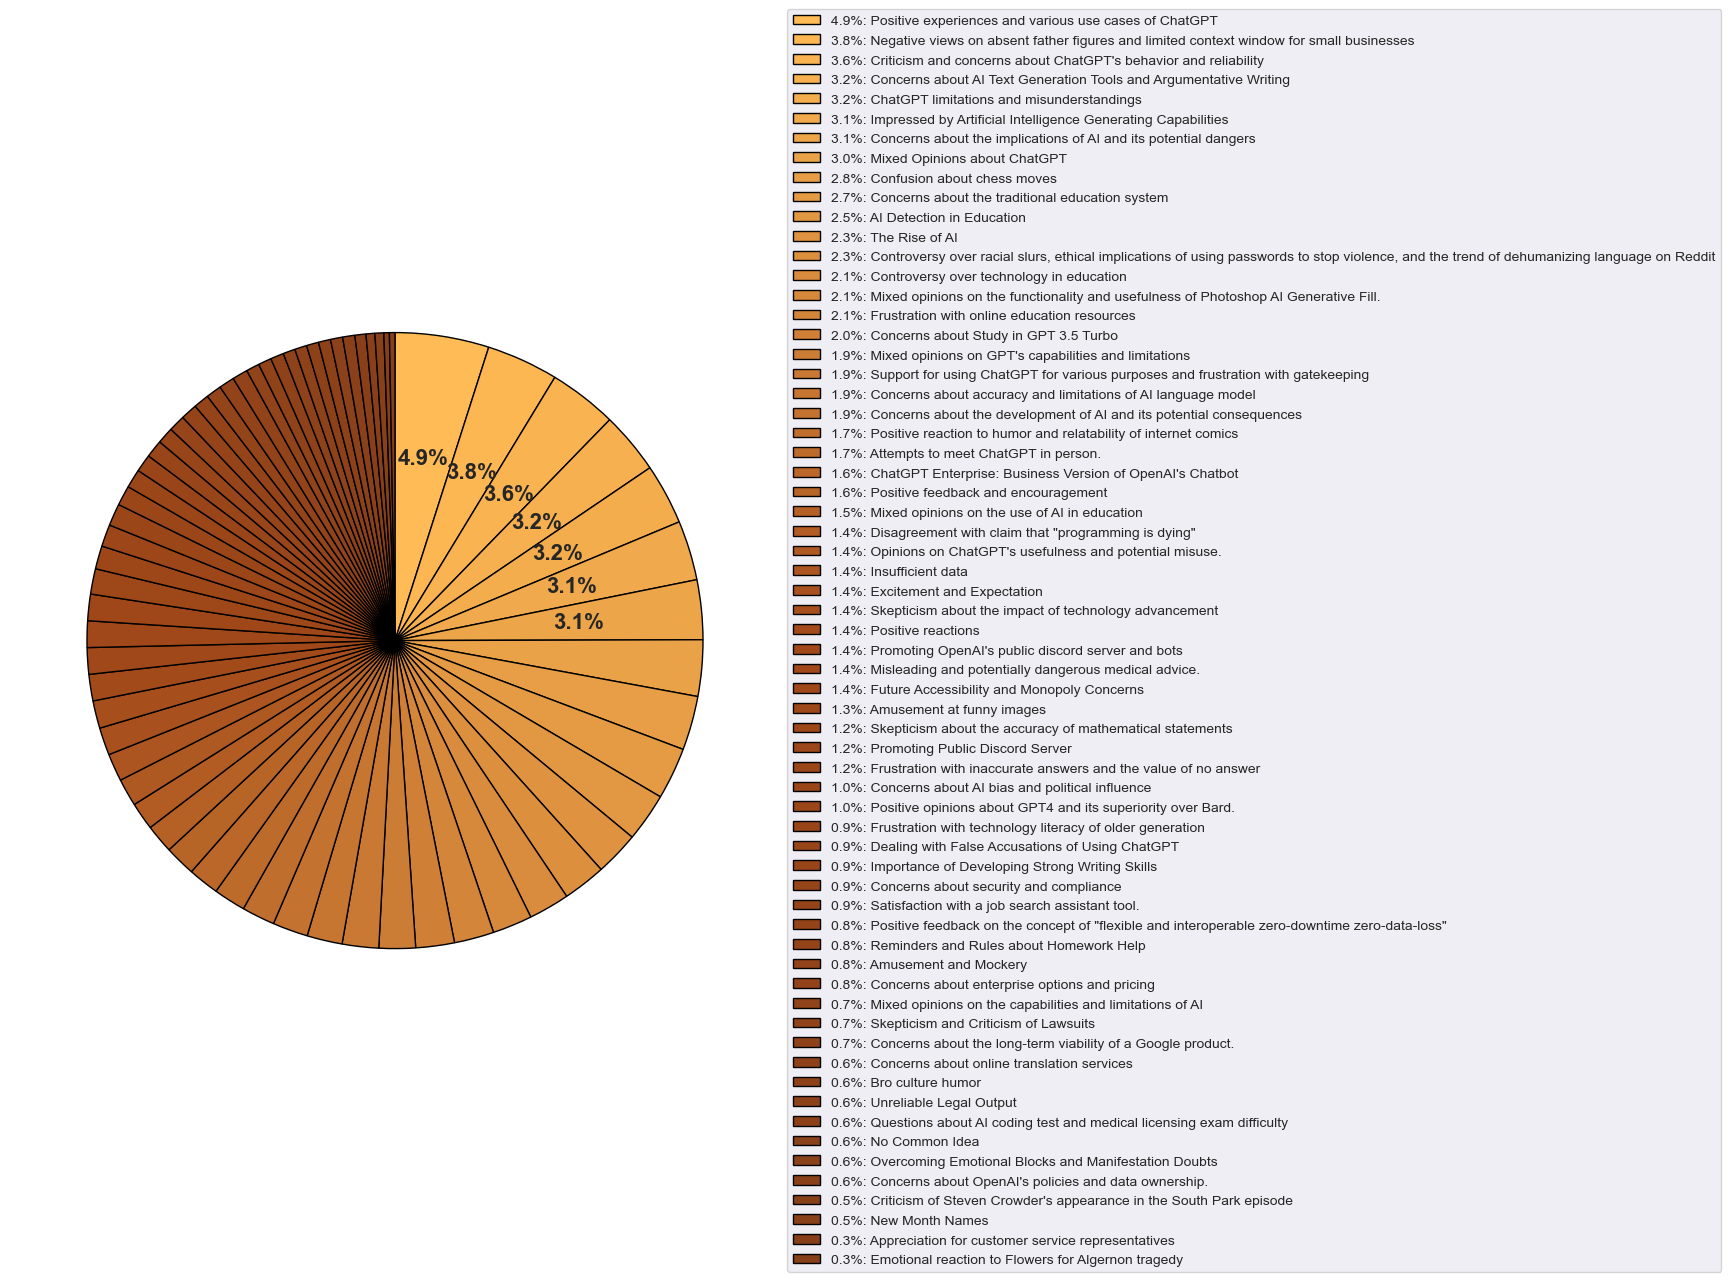

In [36]:
clusters_ = list(clusters.values())
clusters_.sort(key=lambda x: -len(x.elements))
names = [i.clusterName for i in clusters_]
sizes = [len(i.elements) for i in clusters_]
plt.figure(figsize=(20, 10))  # Set the figure size

# Create the pie chart
palette_color = (sns.blend_palette(["#ffbb55", "#a14819","#863f19"], len(clusters_)))
# random.shuffle(palette_color)
# plotting data on chart
#explode= list(np.array(list(reversed(range(0, 5)))) / 100) + [0]*(len(sizes)-5)

plt.pie(sizes, labels=None, colors=palette_color, autopct=lambda x: (str(round(x, 1)) + "%") if x > 3 else "", startangle=90, counterclock=False, textprops={'fontsize': 16, 'fontweight' : 'bold'}, wedgeprops={'edgecolor': 'black', 'linestyle' : '-'}, radius=1, center=(0, 0))

# Create a custom legend-like structure for sector names
legend_labels = [f"{round(100*size/sum(sizes), 1)}%: {label}" for label, size in zip(names, sizes)]
plt.legend(legend_labels, loc="center left", bbox_to_anchor=(1, 0.5))

plt.savefig("Product/chatGPT/plot.png")
# displaying chart
plt.show()